In [12]:
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Pathing
import sys
sys.path.append("../src")
from os.path import join
from results import prefix


from helper import nested_dict_read
from tabulate import tabulate

# Results
import results
reload(results)
print 'Done.'

Results = results.Results

def latex_wrap(table):
    head = '\\begin{table}[!h] \\centering\n'
    tail = '\\caption{} \\label{tab:pseaafasfrch} \\end{table}\n'
    return head + table + tail

def compare(l,date,
            group,types=None,headers=[],variables=[],
            cross_entropy=False,latex=False,print_meta=True,quiet=True,p=2):
    if type(date) == str:
        date = [date]
    assert len(headers) == len(variables), 'Every variable needs a name!'
    lines = []
    if headers == None:
        _headers = ()
    else:
        if print_meta:
            _headers = ['date', 'ID']
        else:
            _headers = ['i']
        _headers += headers + ['e roc', 'e f1','e auto', 'f roc', 'f f1','f auto']
        if cross_entropy:
            _headers += ['vce','tce']
    i = 0
    for ID in l:
        for d in date:
            out_stream = ''
            try:
                r = Results(d, ID,local=False,experiment_group=group)
                if types != None and nested_dict_read(types[0],r.config) != types[1]:
                    continue
                r.final_model
                r.early_model
    #             r.report_losses()
            except IOError as io:
                if not quiet:
                    print d,ID,io
                continue
            except AttributeError as ae:
                if not quiet:
                    print d,ID,ae
                continue
            try:
                if print_meta:
                    out_stream += d[5:10] + ' ' + str(ID) + ' '
                else:
                    out_stream += str(i)+ ' '
                for v in variables:
                    try:
                        out_stream += str(nested_dict_read(v,r.config)) + ' '
                    except KeyError:
                        out_stream += '?? '
    #             out_stream += str(r.config['results']['early_stop_iteration']) + ' '
                ef1, eroc = r.get_f1_roc('test',model='early')
                ff1, froc = r.get_f1_roc('test',model='final')
                out_stream += str(round(eroc,p))+' '+str(round(ef1,p))+' '
                out_stream += str(round(r.early_model['autoencoder_loss'],p)) + ' '
                out_stream += str(round(froc,p))+' '+str(round(ff1,p)) + ' '
                out_stream += str(round(r.final_model['autoencoder_loss'],p))
                if cross_entropy:
                    out_stream += ' '
                    out_stream += str(round(r.cent_axis[0,-1],p)) + ' '
                    out_stream += str(round(r.cent_axis[1,-1],p))
                out_stream += '\n'
                i += 1
            except AttributeError as ae:
                pass
            lines.append(out_stream.split(' '))
            del r
    print tabulate(tabular_data=lines,headers=_headers)
    return latex_wrap(tabulate(tabular_data=lines,headers=_headers,tablefmt='latex'))

Done.


# Normalisation comparison
Here the autoencoder runs for 500 and then the classifer runs for 500
* auto_cnn_2_5
* gudi_test_network_2
* dp = 1.0
* l2_losss = 0

In [11]:
headers = ['norm','scale']
variables = ['data:normalisation_type','data:scaling']
print '\nlinear'
compare([1,2,3,4,5,6],date='2016_08_09',group='both',headers=headers,variables=variables)
print '\ntanh'
compare([1,2,3,4,5,6],date='2016_08_10',group='both',headers=headers,variables=variables,types=('autoencoder:activation','tanh'))
print '\nrelu'
compare([7,9,11,13,15,17],date='2016_08_10',group='both',headers=headers,variables=variables,types=('autoencoder:activation','relu'))
print '\nsigmoid'
compare([8,10,12,14,16,18],date='2016_08_10',group='both',headers=headers,variables=variables,types=('autoencoder:activation','sigmoid'))


linear
date      ID  norm      scale      e roc    e f1    e auto    f roc    f f1    f auto
------  ----  --------  -------  -------  ------  --------  -------  ------  --------
08_09      1  contrast  none       0.546   0.188     0.191    0.753   0.366     0.831
08_09      2  contrast  [-1,1]     0.462   0.188     0.092    0.716   0.32      1.524
08_09      3  face      none       0.516   0.188     0.057    0.75    0.38      0.201
08_09      4  face_ps   none       0.474   0.188     0.031    0.763   0.449     0.109
08_09      5  none      [-1,1]     0.504   0.188     0.08     0.737   0.326     1.917
08_09      6  none      none       0.547   0.188     0.1      0.666   0.302     6.115

tanh
date      ID  norm      scale      e roc    e f1    e auto    f roc    f f1    f auto
------  ----  --------  -------  -------  ------  --------  -------  ------  --------
08_10      1  contrast  none       0.418   0.188     0.195    0.751   0.354     0.306
08_10      2  contrast  [-1,1]     0.456

# What happens if tanh is the activation function everywhere?

In [102]:
headers = ['it']
variables = ['global:iterations']
compare([22],date='2016_08_10',group='both',headers=headers,variables=variables)

date      ID    it    e roc    e f1    e auto    f roc    f f1    f auto
------  ----  ----  -------  ------  --------  -------  ------  --------
08_10     22  1000    0.549   0.203     0.038    0.789   0.391     0.056


# L2 Reg 
Add varying amounts of L2 loss into the network. The L2 loss is applied to all weights and not the biases

In [81]:
headers = ['l2coeff','it']
variables = ['global:l2_coeff','global:iterations']
compare([1,2,3,4,5],date='2016_08_10',group='l2loss',headers=headers,variables=variables,cross_entropy=True)

date      ID    l2coeff    it    e roc    e f1    e auto    f roc    f f1    f auto    vce    tce
------  ----  ---------  ----  -------  ------  --------  -------  ------  --------  -----  -----
08_10      1      0      1000     0.45    0.19      0.03     0.77    0.46      0.11   0.53   0.07
08_10      2      0.001  1000     0.56    0.19      0.03     0.74    0.41      0.05   0.46   0.11
08_10      3      0.01   1000     0.45    0.19      0.03     0.71    0.36      0.04   0.33   0.18
08_10      4      0.1    1000     0.54    0.19      0.04     0.66    0.28      0.04   0.3    0.26
08_10      5      0.5    1000     0.5     0.19      0.04     0.46    0.19      0.04   0.32   0.33


u'\\begin{table}[!h] \\centering\n\\begin{tabular}{lrrrrrrrrrrr}\n\\hline\n date   &   ID &   l2coeff &   it &   e roc &   e f1 &   e auto &   f roc &   f f1 &   f auto &   vce &   tce \\\\\n\\hline\n 08\\_10  &    1 &     0     & 1000 &    0.45 &   0.19 &     0.03 &    0.77 &   0.46 &     0.11 &  0.53 &  0.07 \\\\\n 08\\_10  &    2 &     0.001 & 1000 &    0.56 &   0.19 &     0.03 &    0.74 &   0.41 &     0.05 &  0.46 &  0.11 \\\\\n 08\\_10  &    3 &     0.01  & 1000 &    0.45 &   0.19 &     0.03 &    0.71 &   0.36 &     0.04 &  0.33 &  0.18 \\\\\n 08\\_10  &    4 &     0.1   & 1000 &    0.54 &   0.19 &     0.04 &    0.66 &   0.28 &     0.04 &  0.3  &  0.26 \\\\\n 08\\_10  &    5 &     0.5   & 1000 &    0.5  &   0.19 &     0.04 &    0.46 &   0.19 &     0.04 &  0.32 &  0.33 \\\\\n\\hline\n\\end{tabular}\\caption{} \\label{tab:pseaafasfrch} \\end{table}\n'

If you look at the loss graph of ID3 you see that there is very little overfitting, the following two runs try to find out if doubling the number of iterations for this ID can get a better roc or f1. I reran ID0 just for a comparison and extra sanity check

date      ID    l2coeff    it    e roc    e f1    e auto    f roc    f f1    f auto    vce    tce
------  ----  ---------  ----  -------  ------  --------  -------  ------  --------  -----  -----
08_10      6        0.1  2000     0.56    0.19      0.03     0.74    0.35      0.04   0.3    0.26
08_10      7        0    2000     0.46    0.19      0.03     0.77    0.45      0.15   0.56   0.05
\begin{table}[!h] \centering
\begin{tabular}{lrrrrrrrrrrr}
\hline
 date   &   ID &   l2coeff &   it &   e roc &   e f1 &   e auto &   f roc &   f f1 &   f auto &   vce &   tce \\
\hline
 08\_10  &    6 &       0.1 & 2000 &    0.56 &   0.19 &     0.03 &    0.74 &   0.35 &     0.04 &  0.3  &  0.26 \\
 08\_10  &    7 &       0   & 2000 &    0.46 &   0.19 &     0.03 &    0.77 &   0.45 &     0.15 &  0.56 &  0.05 \\
\hline
\end{tabular}\caption{} \label{tab:pseaafasfrch} \end{table}



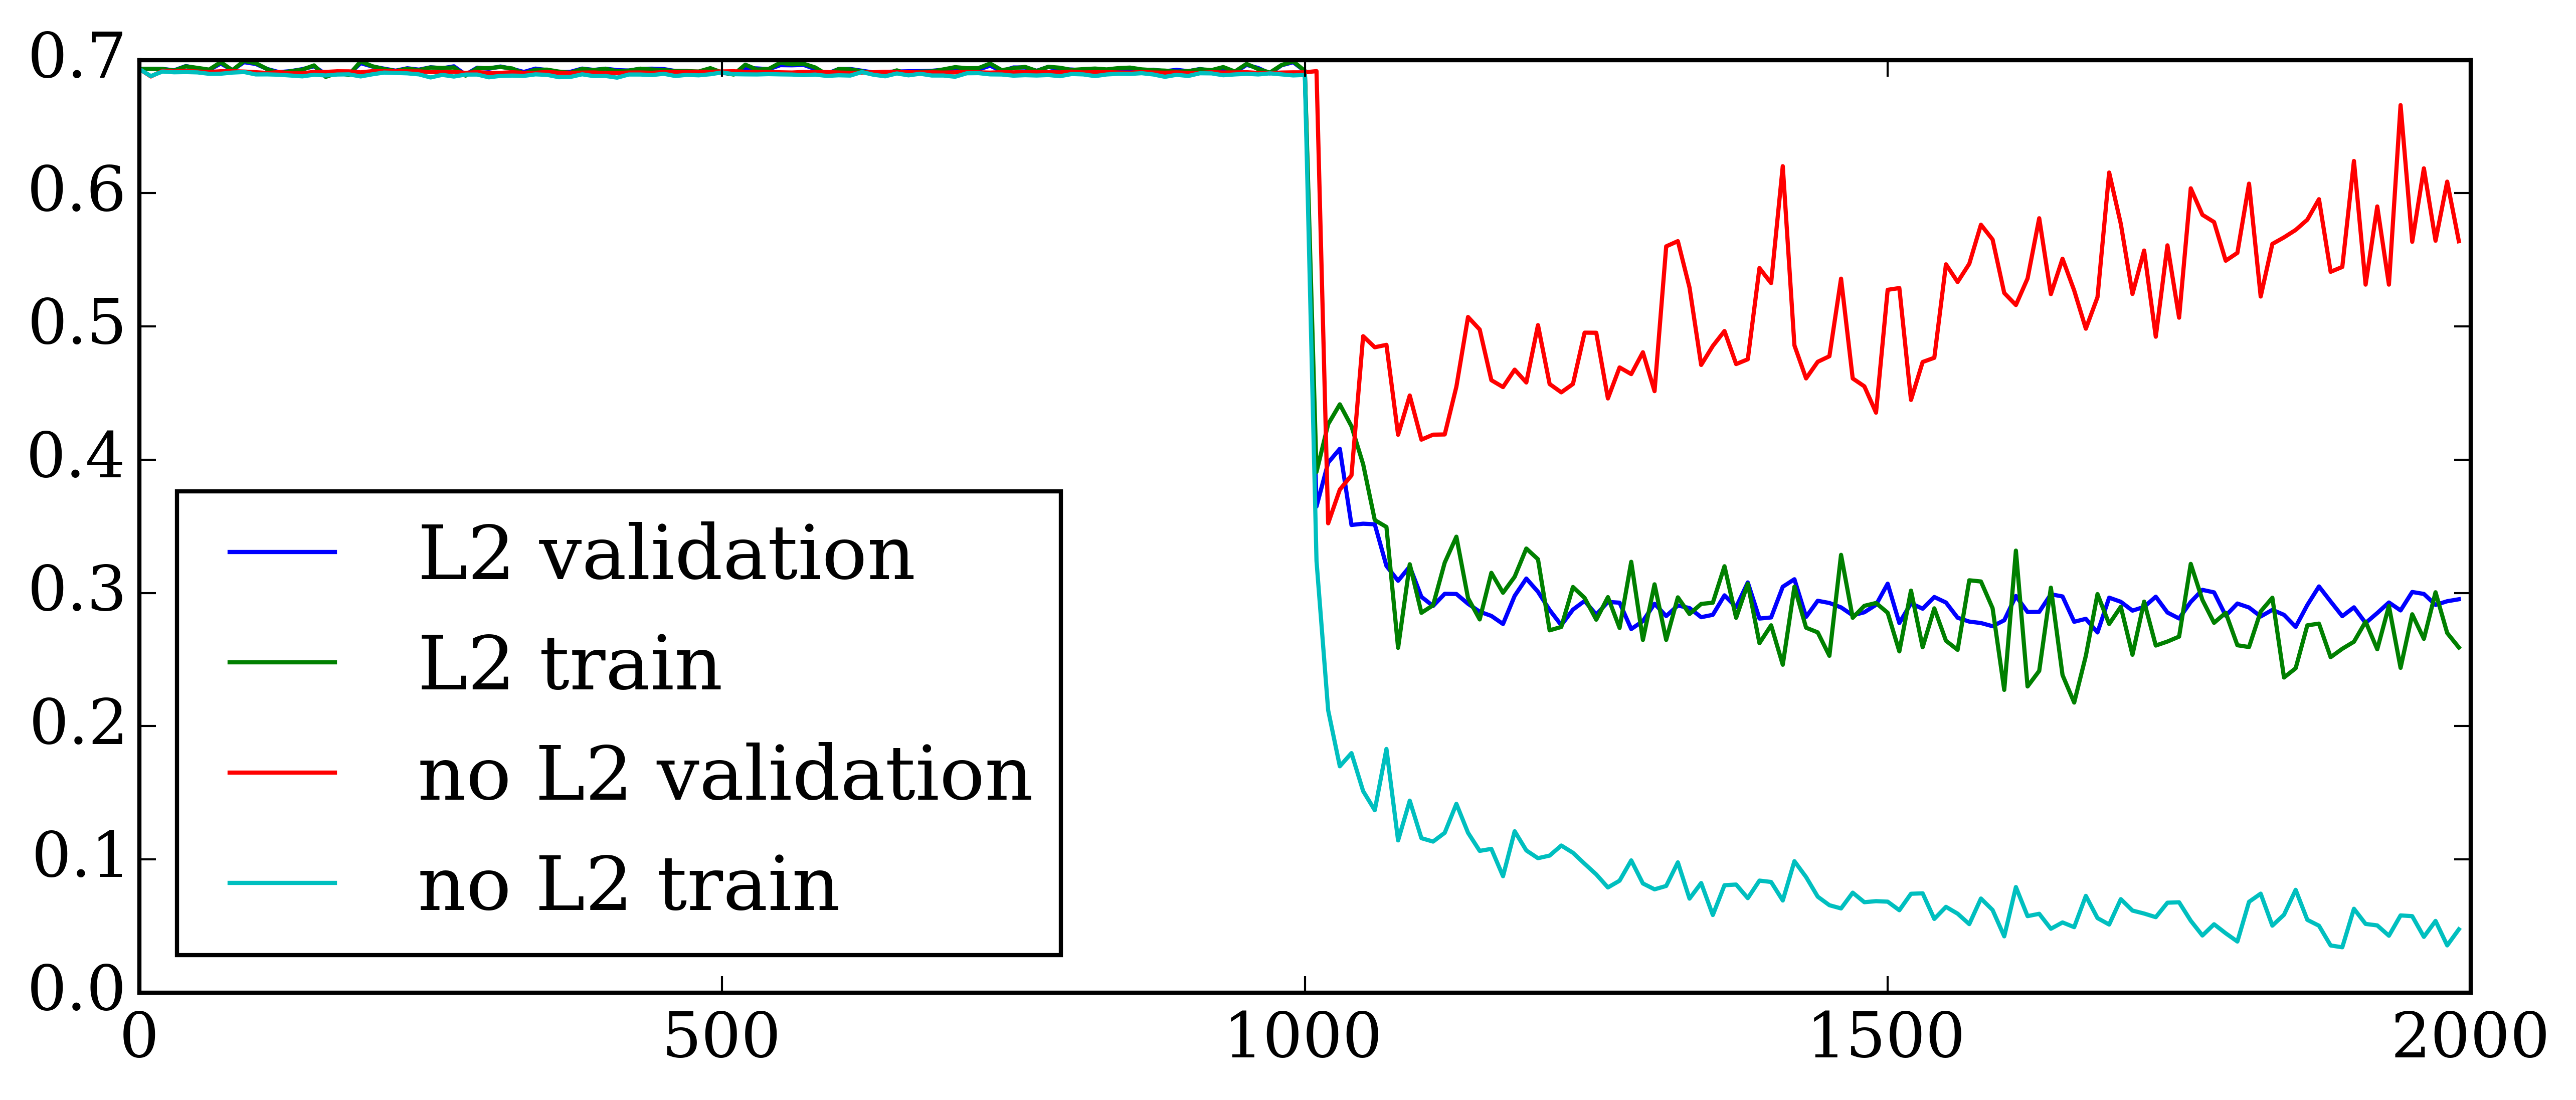

In [84]:
print compare([6,7],date='2016_08_10',group='l2loss',headers=headers,variables=variables,cross_entropy=True)

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
matplotlib.rcParams['savefig.dpi'] = 600
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['figure.dpi'] = 400

id6 = Results('2016_08_10',6,local=False,experiment_group='l2loss')
id7 = Results('2016_08_10',7,local=False,experiment_group='l2loss')
plt.plot(id6.x_axis,id6.cent_axis[0],label='L2 validation')
plt.plot(id6.x_axis,id6.cent_axis[1],label='L2 train')
plt.plot(id7.x_axis,id7.cent_axis[0],label='no L2 validation')
plt.plot(id7.x_axis,id7.cent_axis[1],label='no L2 train')
plt.legend(loc=3)
plt.savefig('../report_final/figures/l2.pdf',pad_inches=0.1)
plt.show()

l2 loss doesn't help!

# Network branch point
Varying where to branch the auteoncoder
* auto_cnn_2_cnc = at the first conv layer
* auto_cnn_2_mpc = at the max pool
* auto_cnn_2_5 = the standard structure

All structures have tied weights, no dropout as usual
I chose tanh as the final activation for the decoder because of the comparison results

In [107]:
headers = ['decoder']
variables = ['autoencoder:decoder']
compare([1,2,3],date='2016_08_10',group='network',headers=headers,variables=variables)

date      ID  decoder           e roc    e f1    e auto    f roc    f f1    f auto
------  ----  --------------  -------  ------  --------  -------  ------  --------
08_10      1  auto_cnn_2_cnc    0.595   0.188     0.019    0.585   0.255     0.034
08_10      2  auto_cnn_2_mpc    0.632   0.188     0.026    0.599   0.273     0.036
08_10      3  auto_cnn_2_5      0.553   0.207     0.038    0.795   0.408     0.05


# Retest the network without autoencoding
For reference

In [7]:
headers = ['it','act']
variables = ['global:iterations','autoencoder:activation']
compare([1,2,3],date='2016_08_10',group='class',headers=headers,variables=variables)

2016_08_10 2 [Errno 2] No such file or directory: '/home/luka/v/lm1015-tmp/data/2016_08_10/class_002/numerical_data/x_axis.ssv'
2016_08_10 3 [Errno 2] No such file or directory: '/home/luka/v/lm1015-tmp/data/2016_08_10/class_003/numerical_data/x_axis.ssv'
date      ID    it  act      e roc    e f1    e auto    f roc    f f1    f auto
------  ----  ----  -----  -------  ------  --------  -------  ------  --------
08_10      1   500  tanh     0.735   0.396     0.044    0.765   0.442     0.044


Oh dear..

# Dropout
Does dropout at the bottleneck do anything to the best network?

In [2]:
headers = ['dp','it','act']
variables = ['global:dropout_rate','global:iterations','autoencoder:activation']
compare([1,2,3,4,5],date='2016_08_10',group='dropout',headers=headers,variables=variables,cross_entropy=False)

date      ID    dp    it  act       e roc    e f1    e auto    f roc    f f1    f auto
------  ----  ----  ----  ------  -------  ------  --------  -------  ------  --------
08_10      1   0.6  1000  linear    0.53    0.188     0.034    0.77    0.461     0.065
08_10      2   0.7  1000  linear    0.377   0.188     0.034    0.766   0.465     0.08
08_10      3   0.8  1000  linear    0.517   0.188     0.034    0.775   0.47      0.091
08_10      4   0.9  1000  linear    0.536   0.188     0.033    0.77    0.478     0.1
08_10      5   1    1000  linear    0.591   0.188     0.031    0.773   0.474     0.129
\begin{tabular}{lrrrlrrrrrr}
\hline
 date   &   ID &   dp &   it & act    &   e roc &   e f1 &   e auto &   f roc &   f f1 &   f auto \\
\hline
 08\_10  &    1 &  0.6 & 1000 & linear &   0.53  &  0.188 &    0.034 &   0.77  &  0.461 &    0.065 \\
 08\_10  &    2 &  0.7 & 1000 & linear &   0.377 &  0.188 &    0.034 &   0.766 &  0.465 &    0.08  \\
 08\_10  &    3 &  0.8 & 1000 & linear &   0.5

# Other things
* Batch weighting- so that the network sees high intensity expressions more often
* Image cropping - this could be really useful for the rare labels
* Show examples for different types of labels, useful for demonstration?

In [13]:
headers = ['threshold','remove']
variables = ['data:threshold','data:remove_empty_labels']
compare([4,5,6,7],date='2016_08_10',group='network',headers=headers,variables=variables,cross_entropy=False)
headers = ['threshold','remove','c']
variables = ['data:threshold','data:remove_empty_labels','data:good_sample_criteria']
compare([1,2,3,4,5,6],date='2016_08_12',group='network',headers=headers,variables=variables,cross_entropy=False)

date      ID    threshold  remove      e roc    e f1    e auto    f roc    f f1    f auto
------  ----  -----------  --------  -------  ------  --------  -------  ------  --------
08_10      4            1  True        0.55    0.193     0.035    0.776   0.364     0.053
08_10      5            2  True        0.445   0.137     0.038    0.835   0.371     0.052
08_10      6            1  False       0.554   0.207     0.038    0.788   0.39      0.057
08_10      7            2  False       0.576   0.153     0.038    0.832   0.374     0.052
2016_08_12 1 [Errno 2] No such file or directory: '/home/luka/v/lm1015-tmp/data/2016_08_12/network_001/numerical_data/x_axis.ssv'
date      ID    threshold  remove      c    e roc    e f1    e auto    f roc    f f1    f auto
------  ----  -----------  --------  ---  -------  ------  --------  -------  ------  --------
08_12      2            1  True        1    0.532   0.188     0.033    0.756   0.445     0.051
08_12      3            1  True        2    0

In [16]:
print l

\begin{tabular}{lrlrrrrrr}
\hline
 date   &   ID & enc   &   e roc &   e f1 &   e auto &   f roc &   f f1 &   f auto \\
\hline
 08\_15  &    1 & False &   0.662 &  0.274 &   10.578 &   0.69  &  0.297 &   15.759 \\
 08\_15  &    2 & True  &   0.716 &  0.332 &   13.598 &   0.728 &  0.338 &   20.73  \\
\hline
\end{tabular}


In [19]:
headers = ['act']
variables = ['autoencoder:activation']


type_list = ['contrast', 'contrast_face_ps','face','face_ps','none_[-1,1]','none_[0,1]','contrast_face']
for t in type_list:
    print t,'\n############'
    l = compare([i for i in xrange(30)],
                date=['2016_08_20','2016_08_21','2016_08_22'],
                group='compare_process',
                headers=headers,
                variables=variables,
                cross_entropy=False,
                types=('data:normalisation',t),
                print_meta=True)
    print

contrast 
############
date      ID  act        e roc    e f1    e auto    f roc    f f1    f auto
------  ----  -------  -------  ------  --------  -------  ------  --------
08_20      3  relu      0.589   0.1883    0.2536   0.7459  0.3599    0.6452
08_20      4  linear    0.3963  0.1883    0.1901   0.7357  0.3406    1.4573
08_20      5  tanh      0.613   0.1883    0.1976   0.7247  0.3527    0.3492
08_22      7  sigmoid   0.5418  0.1948    0.2199   0       0.1883    0.2844

contrast_face_ps 
############
date      ID  act        e roc    e f1    e auto    f roc    f f1    f auto
------  ----  -------  -------  ------  --------  -------  ------  --------
08_20      1  linear    0.4934  0.1883    0.1214   0.8162  0.452     0.1697
08_22      1  sigmoid   0.5171  0.2022    0.1257   0.0833  0.1883    0.128
08_20      2  tanh      0.4908  0.1883    0.1226   0.8192  0.4583    0.1288
08_21      3  relu      0.6304  0.1883    0.125    0.8079  0.4434    0.1431
08_21      4  linear    0.4871  0.

In [6]:
headers = ['type','act']
variables = ['data:normalisation','autoencoder:activation']

l = compare([i for i in xrange(30)],
            date=['2016_08_20','2016_08_21','2016_08_22'],
            group='compare_process',
            headers=headers,
            variables=variables,
            cross_entropy=False,
            types=('autoencoder:activation','sigmoid'),
            print_meta=False)
print l

  i  type              act        e roc    e f1    e auto    f roc    f f1    f auto
---  ----------------  -------  -------  ------  --------  -------  ------  --------
  0  contrast_face_ps  sigmoid     0.52    0.2       0.13     0.08    0.19      0.13
  1  face              sigmoid     0.47    0.2       0.1      0.72    0.35      0.13
  2  face_ps           sigmoid     0.62    0.23      0.04     0.81    0.46      0.05
  3  none_[-1,1]       sigmoid     0.49    0.2       0.12     0.73    0.31      0.36
  4  none_[0,1]        sigmoid     0.47    0.19      0.09     0.65    0.29      0.46
  5  contrast_face     sigmoid     0.44    0.19      0.25     0.71    0.34      0.26
  6  contrast          sigmoid     0.54    0.19      0.22     0       0.19      0.28
\begin{table}[!h] \centering
\begin{tabular}{rllrrrrrr}
\hline
   i & type             & act     &   e roc &   e f1 &   e auto &   f roc &   f f1 &   f auto \\
\hline
   0 & contrast\_face\_ps & sigmoid &    0.52 &   0.2  &     0.13 & 

In [28]:
headers = ['it','face','ps','noise','std','act']
variables = ['global:iterations',
             'data:preprocessing:face',
             'data:preprocessing:per_subject',
             'global:noise',
             'global:noise_stddev',
             'autoencoder:activation']
x = compare([1,2,3,4,5,6],
            date=['2016_08_22','2016_08_23'],
            group='denoising_ae',
            headers=headers,
            variables=variables,
            cross_entropy=False,
            quiet=True)

date      ID    it  face    ps     noise      std  act       e roc    e f1    e auto    f roc    f f1    f auto
------  ----  ----  ------  -----  -------  -----  ------  -------  ------  --------  -------  ------  --------
08_22      1  1000  True    False  True       0.1  linear     0.45    0.19      0.06     0.73    0.34      0.25
08_23      1  1000  True    True   True       1    linear     0.48    0.19      0.03     0.76    0.45      0.15
08_23      2  1000  True    True   True       1    linear     0.43    0.19      0.03     0.82    0.49      0.12
08_22      3  1000  True    True   True       0.1  linear     0.38    0.19      0.03     0.81    0.47      0.14
08_23      3  1500  True    True   True       1    linear     0.43    0.19      0.02     0.81    0.47      0.12


* **08_23 1** and **08_22 3** have always on noise for the autoencoder, afterwards I will times it by alpha

In [20]:
headers = ['face','ps','noise','std','act']
variables = ['data:preprocessing:face',
             'data:preprocessing:per_subject',
             'global:noise',
             'global:noise_stddev',
             'autoencoder:activation']
headers = ['face','act']
variables = ['data:preprocessing:face',
             'autoencoder:activation']
x = compare([1,2,3,4,5,6],
            date=['2016_08_22','2016_08_23'],
            group='class',
            headers=headers,
            variables=variables,
            cross_entropy=False,
            print_meta=False,
            quiet=True)

print
print x

face    act       e roc    e f1    e auto    f roc    f f1    f auto
------  ------  -------  ------  --------  -------  ------  --------
True    linear   0.7865  0.4494    0.6137   0.7945  0.4589    0.7538

\begin{table}[!h] \centering
\begin{tabular}{llrrrrrr}
\hline
 face   & act    &   e roc &   e f1 &   e auto &   f roc &   f f1 &   f auto \\
\hline
 True   & linear &  0.7865 & 0.4494 &   0.6137 &  0.7945 & 0.4589 &   0.7538 \\
\hline
\end{tabular}\caption{} \label{tab:pseaafasfrch} \end{table}



In [87]:
headers = ['network','lrn','weights']
variables = ['global:network',
             'global:local_response_norm',
             'autoencoder:shared_weights']
for j in xrange(2,5):
    x = compare([1,2,3,4,5,6,7,8],
                date=['2016_08_2' + str(i) for i in range(2,5)],
                group='compare_networks',
                headers=headers,
                variables=variables,
                cross_entropy=False,
                print_meta=True,
                types=('global:network','gudi_test_network_'+str(j)),
                quiet=True)
    print '\n\n',x,'\n\n'

    # remember first lrns had just one lrn layer, later ones had the current configtin

date      ID  network              lrn    weights      e roc    e f1    e auto    f roc    f f1    f auto
------  ----  -------------------  -----  ---------  -------  ------  --------  -------  ------  --------
08_23      3  gudi_test_network_2  ??     False         0.38    0.19      0.03     0.79    0.45      0.05
08_24      3  gudi_test_network_2  True   True          0.49    0.19      0.02     0.81    0.47      0.13
08_23      4  gudi_test_network_2  ??     True          0.48    0.19      0.02     0.81    0.48      0.12


\begin{table}[!h] \centering
\begin{tabular}{lrlllrrrrrr}
\hline
 date   &   ID & network             & lrn   & weights   &   e roc &   e f1 &   e auto &   f roc &   f f1 &   f auto \\
\hline
 08\_23  &    3 & gudi\_test\_network\_2 & ??    & False     &    0.38 &   0.19 &     0.03 &    0.79 &   0.45 &     0.05 \\
 08\_24  &    3 & gudi\_test\_network\_2 & True  & True      &    0.49 &   0.19 &     0.02 &    0.81 &   0.47 &     0.13 \\
 08\_23  &    4 & gudi\_test

In [73]:
headers = ['network','lrn','it','dp']
variables = ['global:network',
             'global:local_response_norm',
             'global:iterations',
             'global:dropout_rate']


# DROPOUT EXPERIMENTS

x = compare([i for i in range(20)],
            date=['2016_08_2' + str(i) for i in range(2,5)],
            group='dropout',
            headers=headers,
            variables=variables,
            cross_entropy=False,
            print_meta=False,
            quiet=True)

  i  network              lrn      it    dp    e roc    e f1    e auto    f roc    f f1    f auto
---  -------------------  -----  ----  ----  -------  ------  --------  -------  ------  --------
  0  gudi_test_network_4  True   1500   0.8     0.5     0.19      0.03     0.73    0.36      0.08
  1  gudi_test_network_4  True   1500   0.9     0.63    0.19      0.03     0.71    0.35      0.15
  2  gudi_test_network_4  True   1500   1       0.6     0.19      0.03     0.78    0.42      1.03
  3  gudi_test_network_4  True   2000   0.8     0.52    0.19      0.03     0.77    0.38      1.01
  4  gudi_test_network_3  True   1500   0.8     0.49    0.19      0.03     0.82    0.46      0.13
  5  gudi_test_network_3  True   1500   0.9     0.51    0.19      0.02     0.81    0.46      0.25
  6  gudi_test_network_3  True   2000   0.8     0.57    0.19      0.02     0.81    0.44      0.33
  7  gudi_test_network_3  True   1500   1       0.51    0.19      0.02     0.81    0.46      0.21
  8  gudi_test_netwo

In [71]:
headers = ['net','alpha','it','eit','dp']
variables = ['global:network',
             'autoencoder:function',
             'global:iterations',
             'results:early_stop_iteration',
             'global:dropout_rate']
x = compare([i for i in range(20)],
            date=['2016_08_2' + str(i) for i in range(2,6)],
            group='alpha',
            headers=headers,
            variables=variables,
            cross_entropy=False,
            print_meta=False,
            quiet=True)

  i  net                  alpha       it    eit    dp    e roc    e f1    e auto    f roc    f f1    f auto
---  -------------------  --------  ----  -----  ----  -------  ------  --------  -------  ------  --------
  0  gudi_test_network_4  sigmoid   1500   1000   0.8     0.74    0.36      0.03     0.74    0.36      0.03
  1  gudi_test_network_2  constant  1500    750   0.8     0.81    0.48      0.03     0.8     0.46      0.03
  2  gudi_test_network_3  sigmoid   1500   1000   0.8     0.8     0.46      0.03     0.8     0.44      0.04
  3  gudi_test_network_4  poly      1500    750   0.8     0.52    0.21      0.09     0.67    0.3       0.04
  4  gudi_test_network_2  sigmoid   1500   1000   0.8     0.8     0.46      0.03     0.79    0.46      0.03
  5  gudi_test_network_3  poly      1500    750   0.8     0.78    0.45      0.02     0.79    0.44      0.03
  6  gudi_test_network_4  flip      1500   1000   0.8     0.6     0.26      0.06     0.61    0.27      0.07
  7  gudi_test_network_2  po

In [85]:
headers = ['network','lrn','weights','act']
variables = ['global:network',
             'global:local_response_norm',
             'autoencoder:shared_weights',
             'autoencoder:activation']
x = compare([1,2,3,4,5,6,7,8],
            date=['2016_08_2' + str(i) for i in range(2,5)],
            group='compare_networks',
            headers=headers,
            variables=variables,
            cross_entropy=False,
            print_meta=True,
            quiet=True)
print x

date      ID  network              lrn    weights    act       e roc    e f1    e auto    f roc    f f1    f auto
------  ----  -------------------  -----  ---------  ------  -------  ------  --------  -------  ------  --------
08_23      1  gudi_test_network_3  ??     True       linear     0.56    0.19      0.02     0.8     0.46      0.18
08_24      1  gudi_test_network_4  True   True       linear     0.52    0.19      0.03     0.8     0.44      0.88
08_23      2  gudi_test_network_3  ??     False      linear     0.55    0.19      0.03     0.78    0.41      0.06
08_24      2  gudi_test_network_3  True   True       linear     0.52    0.19      0.02     0.8     0.45      0.22
08_23      3  gudi_test_network_2  ??     False      linear     0.38    0.19      0.03     0.79    0.45      0.05
08_24      3  gudi_test_network_2  True   True       linear     0.49    0.19      0.02     0.81    0.47      0.13
08_23      4  gudi_test_network_2  ??     True       linear     0.48    0.19      0.02  

In [94]:
headers = ['network','lrn','scale','act']
variables = ['global:network',
             'global:local_response_norm',
             'data:full:resize_scale',
             'autoencoder:activation']
x = compare([i for i in xrange(50)],
            date=['2016_08_26'],
            group='big_input',
            headers=headers,
            variables=variables,
            cross_entropy=False,
            print_meta=True,
            quiet=True)

date      ID  network              lrn      scale  act       e roc    e f1    e auto    f roc    f f1    f auto
------  ----  -------------------  -----  -------  ------  -------  ------  --------  -------  ------  --------
08_26     12  gudi_test_network_2  False      0.1  linear     0.76    0.38      0.25     0.75    0.38      0.31
08_26     21  gudi_test_network_2  False      0.5  linear     0.8     0.45      1.31     0.79    0.43      1.69
08_26     28  gudi_test_network_4  True       0.8  linear     0.5     0.19      0.03     0.79    0.41      0.87
08_26     29  gudi_test_network_2  True       0.8  linear     0.51    0.19      0.03     0.82    0.48      0.18


In [15]:
headers = ['noise']
variables = ['global:noise_stddev']
x = compare([i for i in xrange(50)],
            date=['2016_08_28'],
            group='noise',
            headers=headers,
            variables=variables,
            cross_entropy=False,
            print_meta=True,p=5,
            quiet=True)

date      ID    noise    e roc     e f1    e auto    f roc     f f1    f auto
------  ----  -------  -------  -------  --------  -------  -------  --------
08_28      2      0    0.4934   0.18831   0.52044  0.47887  0.18831   0.51427
08_28      3      0.1  0.49351  0.18832   0.52158  0.53447  0.18831   0.51257
